In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import ghalton
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
from utils import clean,to_radian,hann,res_to_rad,ax_to_w,rep_to_angle
from Bessel_Interp import generate_halton_points
from rotation_2d import rot_cost_func, imrotate
from rotation_3d import rotate_coords_3d
from visualize import plot_cost_func, plot_cost_func_t, plot_volume
from cost_functions import cf_ssd
from mask import sphere_mask

In [4]:
oct13_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_10.p','rb'))
oct13_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_8.p','rb'))
oct13_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_6_4.p','rb'))
oct13_dict_5mm_trans = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_5mm_trans.p','rb'))

In [5]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/Oct_13_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()
#pickle.dump(axes_dict,open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/axes_dict.p','wb'))

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']


# Mask in Fourier Domain

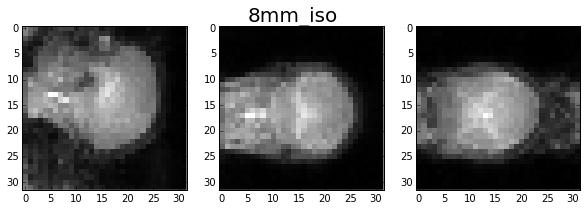

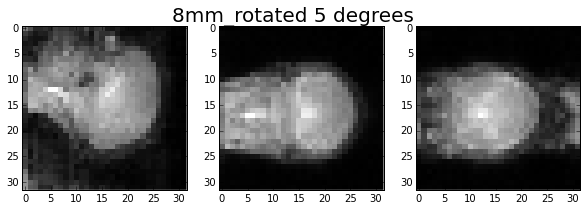

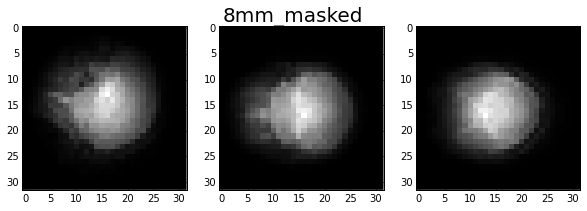

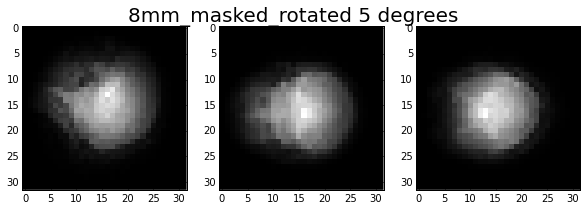

In [67]:
# Take two sample volumes
rot_ax = 'x'
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5, 0)]

res = '8mm'
rad = res_to_rad(res)

testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)

plot_volume(testVol1,'8mm','iso')
plot_volume(testVol2,'8mm','rotated 5 degrees')
plot_volume(testVol1_masked,'8mm','masked')
plot_volume(testVol2_masked,'8mm','masked_rotated 5 degrees')

In [68]:
# Create a disk shaped bessel filter in 3d
def bessel_filter_3d(volume_org):
    volume = volume_org.copy()
    Vb = np.zeros(volume.shape)
    s = (volume.shape[0]-1)/2.
    x = np.linspace(-s, s, volume.shape[1])
    y = np.linspace(-s, s, volume.shape[0])
    z = np.linspace(-s, s, volume.shape[2])
    xx, yy, zz = np.meshgrid(x,y,z)
    for i in np.arange(-s, s+1.0):
        for j in np.arange(-s, s+1.0):
            for k in np.arange(-s, s+1.0):

                R = np.sqrt((xx-j)**2 + (yy-i)**2 + (zz-k)**2)
                mask_R = (R == 0)
                Bess = np.zeros(R.shape)
                Bess[~mask_R] = ((np.sin(np.pi*R[~mask_R])/(np.pi*R[~mask_R]))-np.cos(np.pi*R[~mask_R]))/(2*np.pi*(R[~mask_R]**2))
                Bess[mask_R] = 0.5
                Vb[i+s,j+s,k+s] = np.sum(volume*Bess)/np.sum(Bess)
    return Vb

In [69]:
t0 = time.time()
Vol1_bess = bessel_filter_3d(testVol1)
print time.time()-t0

65.0868289471


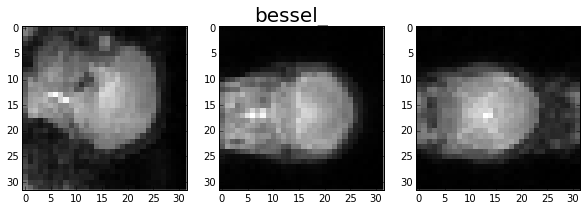

In [70]:
# Apply Bessel filter on sample volume
#Vol1_bess = bessel_filter_3d(testVol1)
plot_volume(Vol1_bess,'bessel')

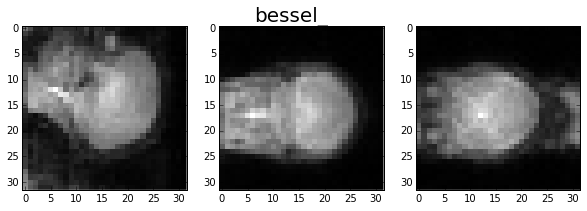

In [71]:
# Apply Bessel filter on sample volume
Vol2_bess = bessel_filter_3d(testVol2)
plot_volume(Vol2_bess,'bessel')

(0.0, 0) xz xy 0_5_to_2_5


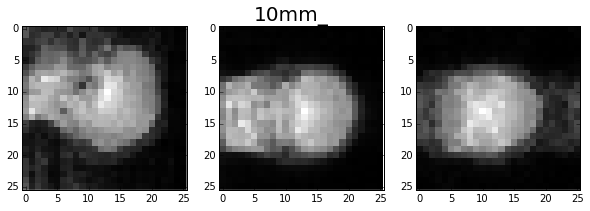

(0.0, 0) xz xy 3_0_to_5_0


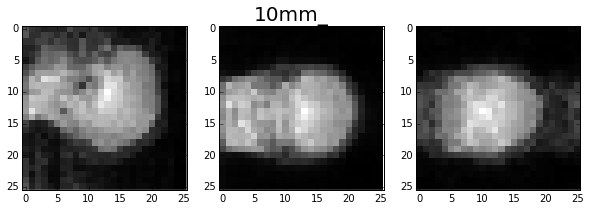

(0.5, 0) xz xy 0_5_to_2_5


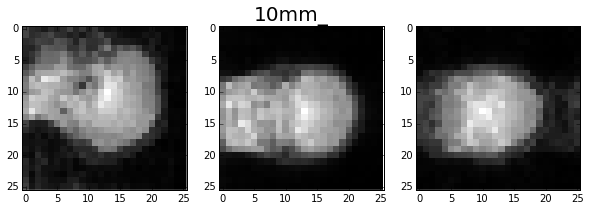

(3.0, 0) xz xy 3_0_to_5_0


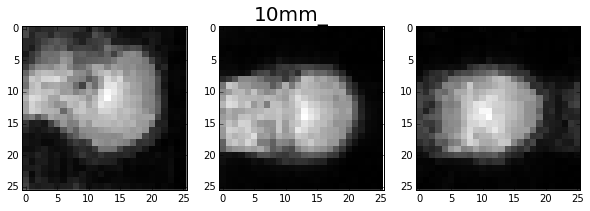

(1.0, 0) xz xy 0_5_to_2_5


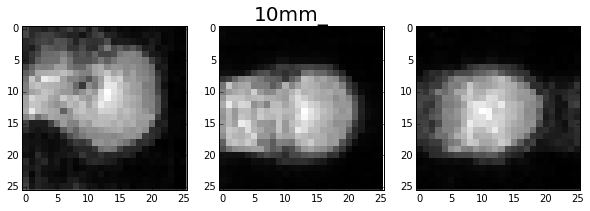

(3.5, 0) xz xy 3_0_to_5_0


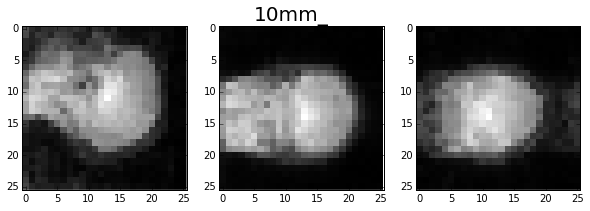

(1.5, 0) xz xy 0_5_to_2_5


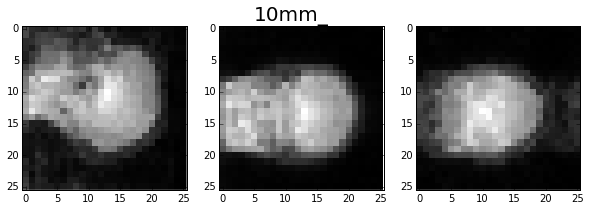

(4.0, 0) xz xy 3_0_to_5_0


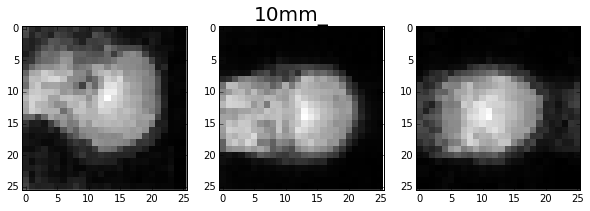

(2.0, 0) xz xy 0_5_to_2_5


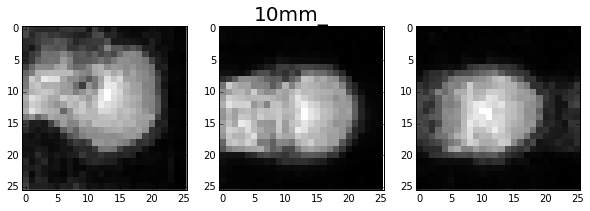

(4.5, 0) xz xy 3_0_to_5_0


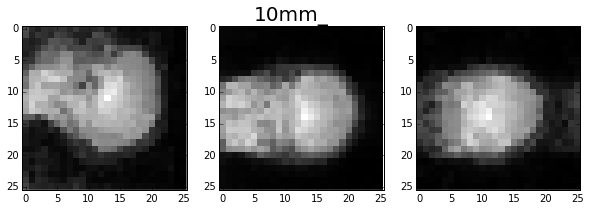

(2.5, 0) xz xy 0_5_to_2_5


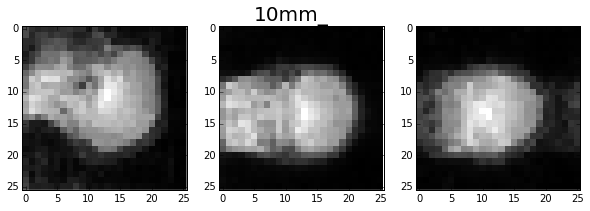

(5.0, 0) xz xy 3_0_to_5_0


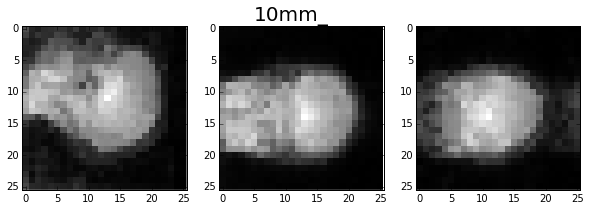

(0.0, 1) xz xy 0_5_to_2_5


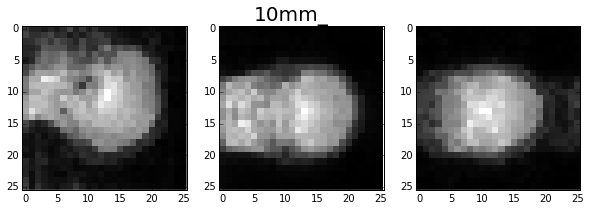

(0.0, 1) xz xy 3_0_to_5_0


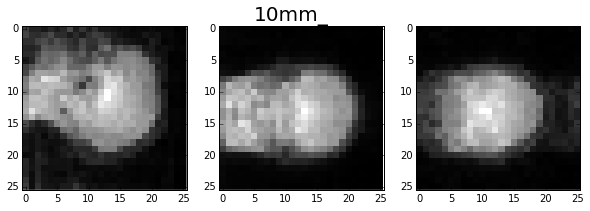

In [9]:
# 10mm
count = 0
ranges = ['0_5_to_2_5','3_0_to_5_0']
for rot_ax, trans_ax in axes_dict.iteritems():
    for rep in xrange(36):
        for rot_range in ranges:
            count += 1
            if count >= 15: break
            rot_angle = rep_to_angle(rep,rot_range)
            print str(rot_angle),rot_ax,trans_ax,rot_range
            plot_volume(oct13_dict_10[rot_ax][trans_ax][rot_range][rot_angle],'10mm')

(0.0, 0) xz xy 0_5_to_2_5


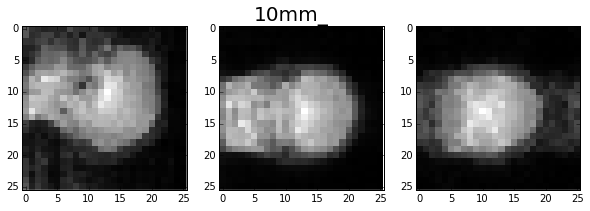

(0.0, 0) xz xy 3_0_to_5_0


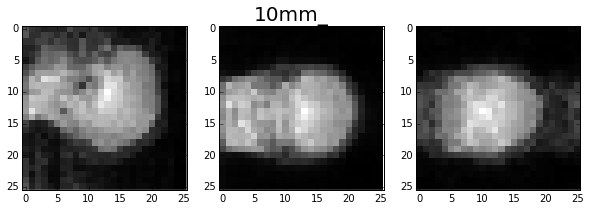

(0.5, 0) xz xy 0_5_to_2_5


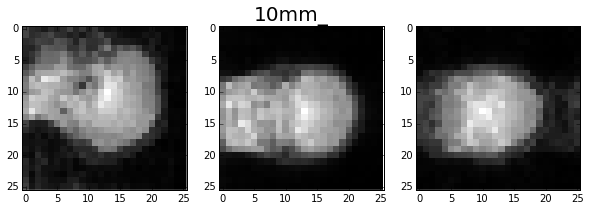

(3.0, 0) xz xy 3_0_to_5_0


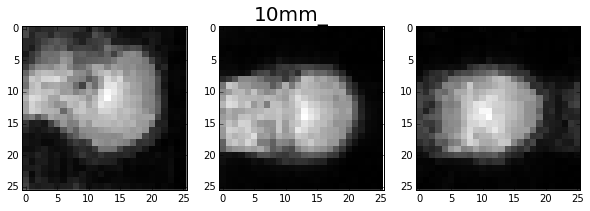

(1.0, 0) xz xy 0_5_to_2_5


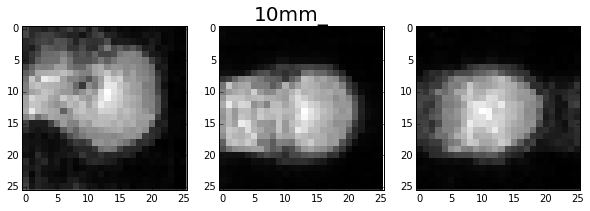

(3.5, 0) xz xy 3_0_to_5_0


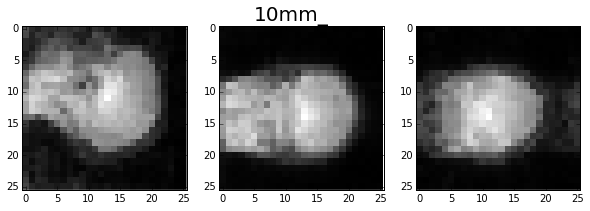

(1.5, 0) xz xy 0_5_to_2_5


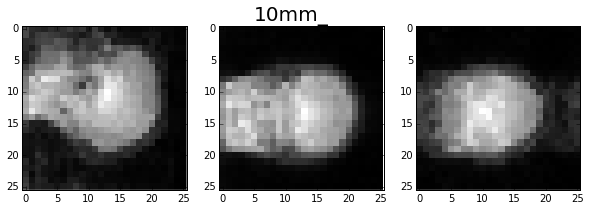

(4.0, 0) xz xy 3_0_to_5_0


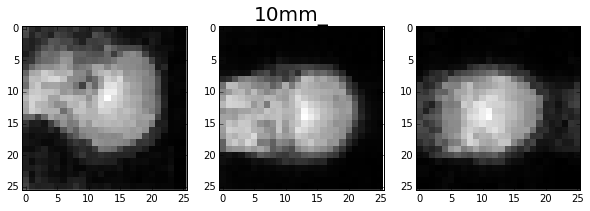

(2.0, 0) xz xy 0_5_to_2_5


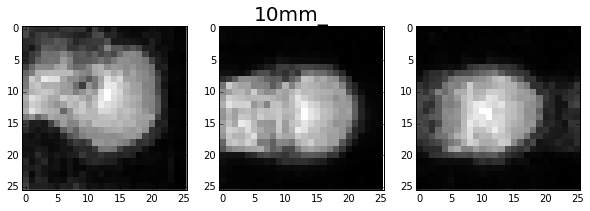

(4.5, 0) xz xy 3_0_to_5_0


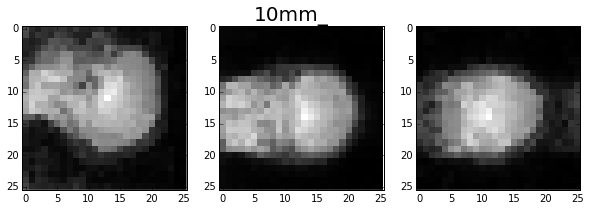

(2.5, 0) xz xy 0_5_to_2_5


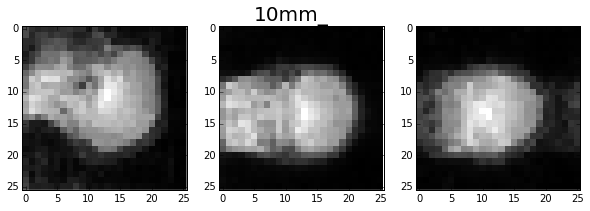

(5.0, 0) xz xy 3_0_to_5_0


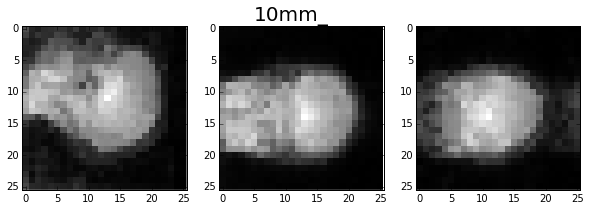

(0.0, 1) xz xy 0_5_to_2_5


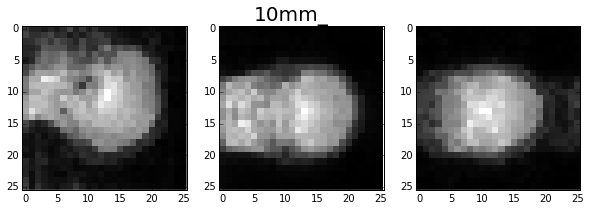

(0.0, 1) xz xy 3_0_to_5_0


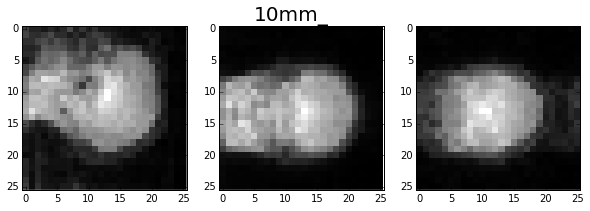

In [11]:
# 8mm
count = 0
ranges = ['0_5_to_2_5','3_0_to_5_0']
for rot_ax, trans_ax in axes_dict.iteritems():
    for rep in xrange(36):
        for rot_range in ranges:
            count += 1
            if count >= 15: break
            rot_angle = rep_to_angle(rep,rot_range)
            print str(rot_angle),rot_ax,trans_ax,rot_range
            plot_volume(oct13_dict_10[rot_ax][trans_ax][rot_range][rot_angle],'10mm')

###  Axis-Angle Rotation

If v is a vector in $R^3$ and $\boldsymbol{\omega}$ is a unit vector describing an axis of rotation about which $\mathbf{v}$ is rotated by an angle $\theta$ the Rodrigues' rotation formula to obtain the rotated vector is

$$\mathbf{v}_\mathrm{rot} = (\cos\theta) \mathbf{v}  + (\sin\theta) (\boldsymbol{\omega} \times \mathbf{v})
  +  (1 - \cos\theta) (\boldsymbol{\omega} \cdot \mathbf{v}) \boldsymbol{\omega}~$$

In [6]:
from rotation_3d import rot_cost_func_3d

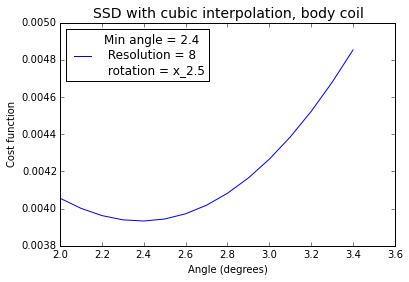

In [14]:
# Test tricubic interpolation on 8mm, x-axis rotation 
rot_ax = 'x'
res = '8'
rad = res_to_rad(res)
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 0)]
thetas = np.arange(2.0,3.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_2.5'%rot_ax, 'body')

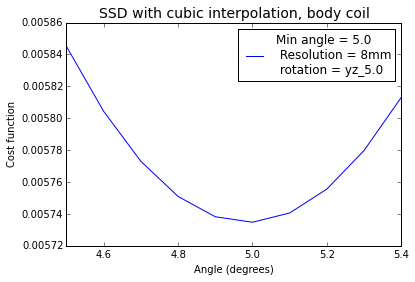

In [38]:
# Test tricubic interpolation on 8mm, yz-axis rotation, yz-axis rotation 
rot_ax = 'yz'
res = '8mm'
rad = res_to_rad(res)
testVol1 = oct13_dict_5mm_trans[res][rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_5mm_trans[res][rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
thetas = np.arange(4.5,5.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

In [14]:
res = '8mm'
rot_ax = 'yz'
testVol1 = oct13_dict_5mm_trans[res][rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
testVol2 = oct13_dict_5mm_trans[res][rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]

translation axis -1 1 0
rotation axis -1 0 -1


In [18]:
wx_t,wy_t,wz_t = ax_to_w(axes_dict[rot_ax])
print 'translation axis',wx_t,wy_t,wz_t
wx,wy,wz = ax_to_w(rot_ax)
print 'rotation axis',wx,wy,wz
new_wx_t,new_wy_t,new_wz_t = rotate_coords_3d(wx_t,wy_t,wz_t, to_radian(5), wx, wy, wz, ox=0,oy=0,oz=0)
print new_wx_t,new_wy_t,new_wz_t

translation axis -1 1 0
rotation axis -1 0 -1
-0.998922435252 1.0010758249 -0.00107756474806


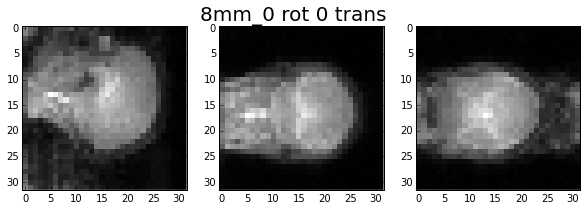

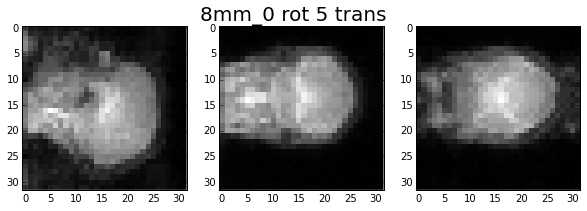

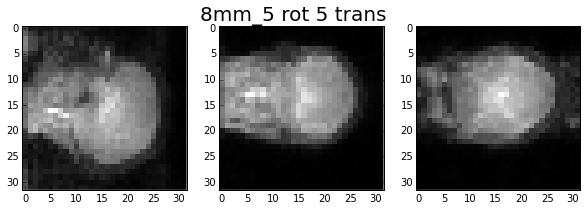

In [19]:
trans = -25./8.
t = [new_wx_t*trans,new_wy_t*trans,new_wz_t*trans]
vol_org = oct13_dict_5mm_trans[res][rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
#vol_trans = translation(testVol1,t)
plot_volume(vol_org,'8mm','0 rot 0 trans')
#plot_volume(vol_trans,'8mm')
#plot_volume(vol_trans-vol_org,'8mm')
plot_volume(testVol1,'8mm','0 rot 5 trans')
plot_volume(testVol2,'8mm','5 rot 5 trans')

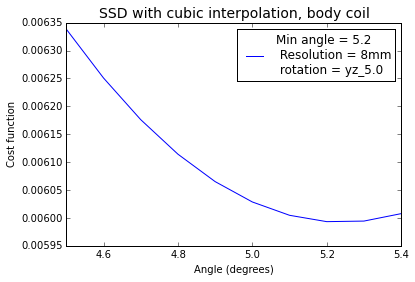

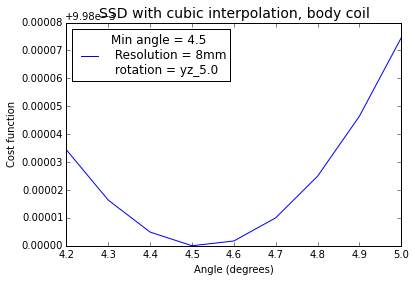

In [92]:
# Test tricubic interpolation on 8mm, yz-axis rotation, 5mm trans
rot_ax = 'yz'
res = '8mm'
rad = res_to_rad(res)
testVol1 = oct13_dict_5mm_trans[res][rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
testVol2 = oct13_dict_5mm_trans[res][rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]
thetas = np.arange(4.5,5.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')
plt.show()
# after shifting
thetas = np.arange(4.2,5.1,0.1)
wx_t,wy_t,wz_t = ax_to_w(axes_dict[rot_ax])
trans = -25./8.
t = [wx_t*trans,wy_t*trans,wz_t*trans]
cost = rot_cost_func_3d(sphere_mask(translation(testVol1,t),rad), 
                        sphere_mask(translation(testVol2,t),rad), 
                        thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')
plt.show()

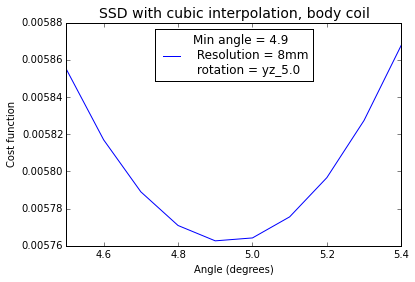

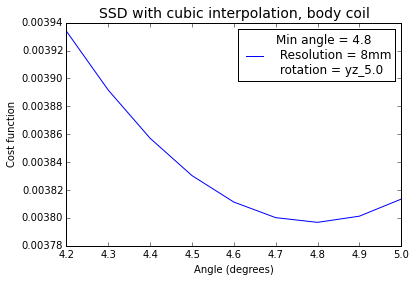

In [96]:
# Test tricubic interpolation on 8mm, yz-axis rotation 
rot_ax = 'yz'
res = '8mm'
rad = res_to_rad(res)
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]
thetas = np.arange(4.5,5.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')
plt.show()
# after shifting
thetas = np.arange(4.2,5.1,0.1)
wx_t,wy_t,wz_t = ax_to_w(axes_dict[rot_ax])
trans = -5./8.
t = [wx_t*trans,wy_t*trans,wz_t*trans]
cost = rot_cost_func_3d(sphere_mask(translation(testVol1,t),rad), 
                        sphere_mask(translation(testVol2,t),rad), 
                        thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')
plt.show()

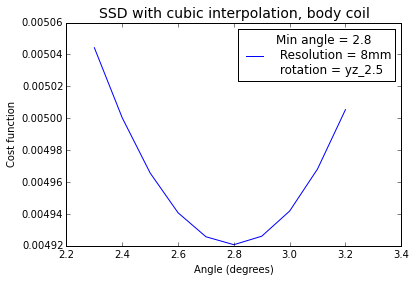

In [35]:
# Test tricubic interpolation on 8mm, x-axis rotation, shifted center
rot_ax = 'yz'
res = '8mm'
rad = res_to_rad(res)
testVol1 = oct13_dict_5mm_trans[res][rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 5)]
testVol2 = oct13_dict_5mm_trans[res][rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 5)]
thetas = np.arange(2.3,3.2,0.1)
wx,wy,wz = ax_to_w(rot_ax)
trans = -25./8.
t = [wx*trans,wy*trans,wz*trans]
cost = rot_cost_func_3d(sphere_mask(translation(testVol1,t),rad), 
                        sphere_mask(translation(testVol2,t),rad), 
                        thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_2.5'%rot_ax, 'body')

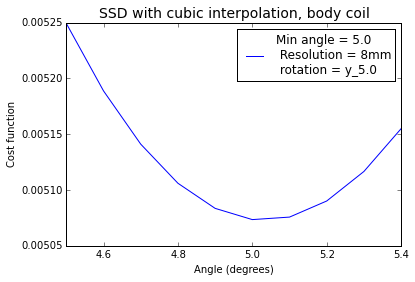

In [16]:
# Test tricubic interpolation on 8mm, y-axis rotation 
rot_ax = 'y'
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(4.5,5.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

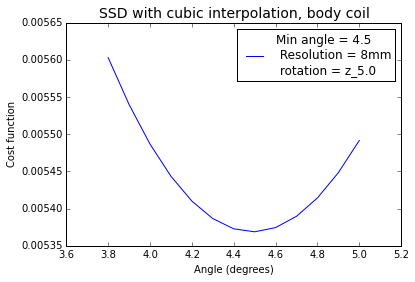

In [20]:
# Test tricubic interpolation on 8mm, z-axis rotation 
rot_ax = 'z'
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(3.8,5.0,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

### Test Multiprocess on cubic rotations

In [249]:
dict_ = sept23_dict_10.copy()
def cubic_rotations(rot_ax):
    cost_dict = {}
    rad = res_to_rad(res)
    ranges = ['0_5_to_2_5','3_0_to_5_0']
    
    if(rot_ax == 'x'): ax = 0
    elif(rot_ax == 'y'): ax = 1
    else: ax = 2
        
    for rot_range in ranges:
        for loop in xrange(6):
            ref = rep_to_angle(loop * 6,rot_range)
            for i in xrange(1,6):
                rep = i + loop * 6
                rot_angle = rep_to_angle(rep,rot_range)
                deg = rot_angle[0]
                thetas = np.arange(-deg-3,deg+3,0.1)
                cost_dict[rot_angle] = rot_cost_func(sphere_mask(dict_[rot_ax][axes_dict[rot_ax]][rot_range][str(ref)],rad),
                                                    sphere_mask(dict_[rot_ax][axes_dict[rot_ax]][rot_range][str(rot_angle)],rad),
                                                    thetas,axis=ax, interpolation='bicubic')
    return cost_dict

In [233]:
if __name__ == '__main__':
    keys =  axes_dict.keys()
    nproc = len(keys)
    pool = multiprocessing.Pool(processes = nproc)
    cost_dict = pool.map(cubic_rotations, keys)
    filename = '/Users/zyzdiana/Desktop/sept23_cubic_%s_rotation.p' % (rot_ax)
    pickle.dump(cost_dict,open(filename,'wb'))

## Translations

In [20]:
from Bessel_Interp import generate_halton_points,circle_mask_points,bessel_rotate_arbitrary_points
from rotation_3d import trilinear_interp

In [19]:
t0 = time.time()
testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)
cost_func = cf_ssd(testVol1_masked,testVol2_masked)
t1 = time.time()
print t1-t0

0.447293043137


In [25]:
t0 = time.time()
cost_func = cf_ssd(testVol1_masked,sphere_mask(testVol2,rad))
t1 = time.time()
print t1-t0

0.226400136948


In [24]:
res = '8mm'
rot_ax = 'yz'
testVol1 = oct13_dict_5mm_trans[res][rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
testVol2 = oct13_dict_5mm_trans[res][rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]

In [25]:
wx_t,wy_t,wz_t = ax_to_w(axes_dict[rot_ax])
print 'translation axis',wx_t,wy_t,wz_t
wx,wy,wz = ax_to_w(rot_ax)
print 'rotation axis',wx,wy,wz
new_wx_t,new_wy_t,new_wz_t = rotate_coords_3d(wx_t,wy_t,wz_t, to_radian(5), wx, wy, wz, ox=0,oy=0,oz=0)
print new_wx_t,new_wy_t,new_wz_t

translation axis -1 1 0
rotation axis -1 0 -1
-0.998922435252 1.0010758249 -0.00107756474806


In [41]:
# rotated axis of translation
trans = np.arange(-4,-3,0.01)
cost_func = trans_cost_func_3d(testVol1, testVol2, trans,new_wx_t,new_wy_t,new_wz_t,1,True)
print trans[np.argmin(cost_func)]*8

-25.12


In [44]:
# Old axis of translation
trans = np.arange(-4,-3,0.01)
cost_func = trans_cost_func_3d(testVol1, testVol2, trans,wx_t,wy_t,wz_t,1,True)
print trans[np.argmin(cost_func)]*8

-25.12


In [49]:
trans = np.arange(-3.5,-3,0.01)
cost_func = trans_cost_func_3d(testVol1, testVol2, trans,new_wx_t,new_wy_t,new_wz_t,3,True)
print trans[np.argmin(cost_func)]*8

-25.28


In [21]:
import scipy.ndimage
def trans_cost_func_3d(vol1, vol2, trans, wx, wy, wz,order=1,mask = True):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    arg: string for plot titles
    '''
    if mask:
        rad = vol1.shape[0]/2
        vol1_masked = sphere_mask(vol1,rad)
    cost_func = np.zeros([len(trans),])
    for idx, t in enumerate(trans):
        new_vol2 = scipy.ndimage.interpolation.shift(vol2,np.array([wx,wy,wz])*t,order=order, mode='wrap')
        if mask:
            cost_func[idx] = cf_ssd(sphere_mask(new_vol2,rad),vol1_masked)
        else:
            cost_func[idx] = cf_ssd(new_vol2,vol1)
    return cost_func

def halton_cost_func_t(N, vol1, vol2, t, wx, wy, wz):
    '''
    N: Number of Halton Sampling Points
    vol1: original image
    vol2: volume to be rotated
    theta: rotation by degrees
    t: list of translations to try
    '''
    cost_func = np.zeros(len(t))
    # generate Halton Sequence in the 32*32*32 grid
    pts = generate_halton_points(N * 2, 3, len(vol1) - 1)
    x1 = 31 * pts[:,0]
    y1 = 31 * pts[:,1]
    z1 = 31 * pts[:,2]
    for idx, th in enumerate(t):
        v2 = trilinear_interp(vol2, x1+wx*th, y1+wy*th, z1+wz*th)
        v1 = trilinear_interp(vol1, x1, y1, z1)
        cost_func[idx] = cf_ssd(v2,v1)
    return cost_func

In [22]:
def translations(res,rot_ax,order = 1,mask = True):
    if ('10' in res): dict_ = sept23_dict_10
    if ('8' in res): dict_ = sept23_dict_8
    if ('6_4' in res): dict_ = sept23_dict_6_4
    cost_dict = {}
    wx,wy,wz = ax_to_w(axes_dict[rot_ax])
    trans = np.arange(-1,1,0.01)
    for rot_range in ranges:
        for loop in xrange(1,6):
            for i in xrange(6):
                ref = rep_to_angle(i,rot_range)
                rep = i + loop * 6
                rot_angle = rep_to_angle(rep,rot_range)
                step = rot_angle[1]
                print ref, rot_angle,step
                cost_dict[rot_angle] = trans_cost_func_3d(dict_[rot_ax][axes_dict[rot_ax]][rot_range][ref],
                                                          dict_[rot_ax][axes_dict[rot_ax]][rot_range][rot_angle],
                                                          trans, wx, wy, wz,order,mask)
    return cost_dict

In [23]:
def translations_5mm_trans(rot_ax, order = 1,mask = False):
    dict_ = oct13_dict_5mm_trans
    resolutions = ['6_4mm','8mm','10mm']
    cost_dict = {}
    wx,wy,wz = ax_to_w(axes_dict[rot_ax])
    for res in resolutions:
        print res,
        cost_dict[res] = {}
        for rot_range in ranges:
            print rot_range
            for loop in xrange(1,6):
                for i in xrange(6):
                    ref = rep_to_angle(i,rot_range)
                    rep = i + loop * 6
                    rot_angle = rep_to_angle(rep,rot_range)
                    step = float(rot_angle[1])*5./float('.'.join(res[:-2].split('_')))
                    trans = np.arange(-np.floor(step)-2,-np.floor(step)+2,0.01)
                    cost_dict[res][rot_angle] = trans_cost_func_3d(dict_[res][rot_ax][axes_dict[rot_ax]][rot_range][ref],
                                                                   dict_[res][rot_ax][axes_dict[rot_ax]][rot_range][rot_angle],
                                                                   trans, wx, wy, wz,order,mask)
    return cost_dict

In [57]:
def translations_5mm_trans_rotated(rot_ax, order = 1,mask = False):
    dict_ = oct13_dict_5mm_trans
    resolutions = ['6_4mm','8mm','10mm']
    cost_dict = {}
    wx_t,wy_t,wz_t = ax_to_w(axes_dict[rot_ax])
    wx,wy,wz = ax_to_w(rot_ax)
    for res in resolutions:
        print res,
        cost_dict[res] = {}
        for rot_range in ranges:
            print rot_range
            for loop in xrange(1,6):
                for i in xrange(6):
                    ref = rep_to_angle(i,rot_range)
                    rep = i + loop * 6
                    rot_angle = rep_to_angle(rep,rot_range)
                    new_wx_t,new_wy_t,new_wz_t = rotate_coords_3d(wx_t,wy_t,wz_t, to_radian(rot_angle[0]), 
                                                                  wx, wy, wz, ox=0,oy=0,oz=0)
                    step = float(rot_angle[1])*5./float('.'.join(res[:-2].split('_')))
                    trans = np.arange(-np.floor(step)-1,-np.floor(step)+1,0.01)
                    cost_dict[res][rot_angle] = trans_cost_func_3d(dict_[res][rot_ax][axes_dict[rot_ax]][rot_range][ref],
                                                                   dict_[res][rot_ax][axes_dict[rot_ax]][rot_range][rot_angle],
                                                                   trans, wx, wy, wz,order,mask)
    return cost_dict

In [56]:
# Linear Translation no mask
cost_trans_linear_nomask = translations_5mm_trans('yz',1,False)
pickle.dump(cost_trans_linear_nomask, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_5mm_trans_cost_trans_linear_nomask.p','wb'))

6_4mm 0_5_to_2_5
3_0_to_5_0
8mm 0_5_to_2_5
3_0_to_5_0
10mm 0_5_to_2_5
3_0_to_5_0


In [92]:
# Cubic Translation no mask
cost_trans_cubic_nomask = translations_5mm_trans('yz',3,False)
pickle.dump(cost_trans_cubic_nomask, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_5mm_trans_cost_trans_cubic_nomask.p','wb'))

6_4mm 0_5_to_2_5
3_0_to_5_0
8mm 0_5_to_2_5
3_0_to_5_0
10mm 0_5_to_2_5
3_0_to_5_0


In [94]:
# Cubic Translation with mask
cost_trans_cubic = translations_5mm_trans('yz',3,True)
pickle.dump(cost_trans_cubic, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_5mm_trans_cost_trans_cubic.p','wb'))

6_4mm 0_5_to_2_5
3_0_to_5_0
8mm 0_5_to_2_5
3_0_to_5_0
10mm 0_5_to_2_5
3_0_to_5_0


In [65]:
# Rotated axis of translation, Linear Translation no mask
cost_trans_linear_nomask = translations_5mm_trans_rotated('yz',1,False)
pickle.dump(cost_trans_linear_nomask, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_5mm_trans_new_cost_trans_linear_nomask.p','wb'))

6_4mm 0_5_to_2_5
3_0_to_5_0
8mm 0_5_to_2_5
3_0_to_5_0
10mm 0_5_to_2_5
3_0_to_5_0


In [61]:
def trans_5mm_linear(res):
    rot_ax = 'yz'
    order = 1
    mask = True
    dict_ = oct13_dict_5mm_trans

    cost_dict = {}
    wx_t,wy_t,wz_t = ax_to_w(axes_dict[rot_ax])
    wx,wy,wz = ax_to_w(rot_ax)

    print res,
    cost_dict[res] = {}
    for rot_range in ranges:
        print rot_range
        for loop in xrange(1,6):
            for i in xrange(6):
                ref = rep_to_angle(i,rot_range)
                rep = i + loop * 6
                rot_angle = rep_to_angle(rep,rot_range)
                new_wx_t,new_wy_t,new_wz_t = rotate_coords_3d(wx_t,wy_t,wz_t, to_radian(rot_angle[0]), 
                                                              wx, wy, wz, ox=0,oy=0,oz=0)
                step = float(rot_angle[1])*5./float('.'.join(res[:-2].split('_')))
                trans = np.arange(-np.floor(step)-1,-np.floor(step)+1,0.01)
                cost_dict[res][rot_angle] = trans_cost_func_3d(dict_[res][rot_ax][axes_dict[rot_ax]][rot_range][ref],
                                                               dict_[res][rot_ax][axes_dict[rot_ax]][rot_range][rot_angle],
                                                               trans, new_wx_t,new_wy_t,new_wz_t,order,mask)
    return cost_dict

In [62]:
# Rotated axis of translation, Linear Translation with mask
keys =  ['6_4mm','8mm','10mm']
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
cost_dict = pool.map(trans_5mm_linear, keys)
filename = '/Users/zyzdiana/Desktop/oct13_5mm_trans_new_cost_trans_linear.p'
pickle.dump(cost_dict,open(filename,'wb'))

8mm 0_5_to_2_5
10mm 0_5_to_2_5
6_4mm 0_5_to_2_5
3_0_to_5_03_0_to_5_03_0_to_5_0




In [63]:
def trans_5mm_cubic(res):
    rot_ax = 'yz'
    order = 3
    mask = True
    dict_ = oct13_dict_5mm_trans

    cost_dict = {}
    wx_t,wy_t,wz_t = ax_to_w(axes_dict[rot_ax])
    wx,wy,wz = ax_to_w(rot_ax)

    print res,
    cost_dict[res] = {}
    for rot_range in ranges:
        print rot_range
        for loop in xrange(1,6):
            for i in xrange(6):
                ref = rep_to_angle(i,rot_range)
                rep = i + loop * 6
                rot_angle = rep_to_angle(rep,rot_range)
                new_wx_t,new_wy_t,new_wz_t = rotate_coords_3d(wx_t,wy_t,wz_t, to_radian(rot_angle[0]), 
                                                              wx, wy, wz, ox=0,oy=0,oz=0)
                step = float(rot_angle[1])*5./float('.'.join(res[:-2].split('_')))
                trans = np.arange(-np.floor(step)-1,-np.floor(step)+1,0.01)
                cost_dict[res][rot_angle] = trans_cost_func_3d(dict_[res][rot_ax][axes_dict[rot_ax]][rot_range][ref],
                                                               dict_[res][rot_ax][axes_dict[rot_ax]][rot_range][rot_angle],
                                                               trans, new_wx_t,new_wy_t,new_wz_t,order,mask)
    return cost_dict

In [64]:
keys =  ['6_4mm','8mm','10mm']
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
cost_dict = pool.map(trans_5mm_cubic, keys)
filename = '/Users/zyzdiana/Desktop/oct13_5mm_trans_new_cost_trans_cubic.p'
pickle.dump(cost_dict,open(filename,'wb'))

10mm 0_5_to_2_5
8mm 0_5_to_2_5
6_4mm 0_5_to_2_5
3_0_to_5_03_0_to_5_03_0_to_5_0




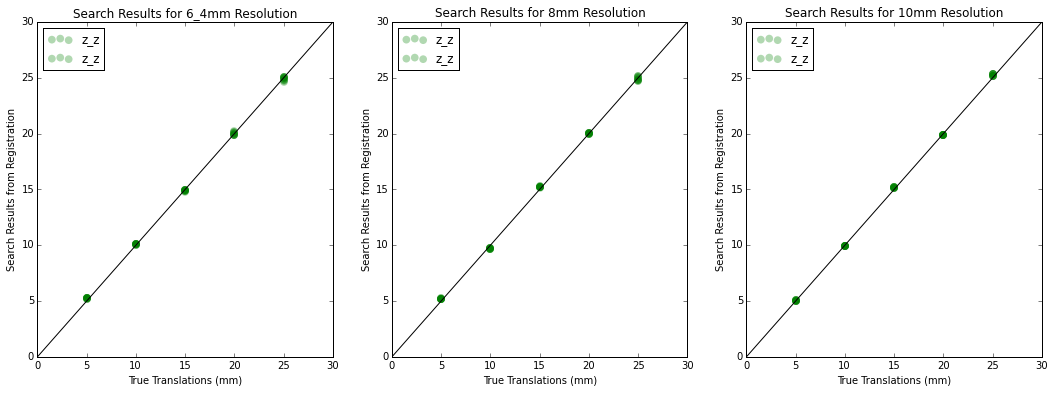

In [91]:
from oct13_visualize import scatter_plot_trans1
resolutions = ['6_4mm','8mm','10mm']
plt.figure(figsize=[18,6])
for idx, res in enumerate(resolutions):
    cost = cost_trans_linear_nomask[res]
    plt.subplot(1,3,idx+1)
    scatter_plot_trans1(cost,res)
plt.show()

In [ ]:
axes_dict = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/axes_dict.p','rb'))
rot_axes = ['xz', 'y', 'yz', 'xy', 'x', 'z']
ax_to_idx = {}
for rot_ax in rot_axes:
    ax_to_idx[rot_ax] = rot_axes.index(rot_ax)
def scatter_plot_trans1(cost_dict, res, axes):
    colors = ['red','blue','green','orange','brown','purple']
    ranges = ['0_5_to_2_5','3_0_to_5_0']
    count = 0
    trans = np.arange(-1,1,0.01)
    for idx, rot_ax in enumerate(axes):
        count = 1
        for rot_range in ranges:
            for loop in xrange(1,6):
                for i in xrange(6):
                    rep = i + loop * 6
                    if(count == 1): 
                        label = rot_ax+'_'+axes_dict[rot_ax]
                        count = 0
                    else: label = None
                    rot_angle = rep_to_angle(rep,rot_range)
                    step = rot_angle[1]
                    cost = cost_dict[rot_angle]
                    y = abs(trans[np.argmin(cost,axis=0)])*float(res[:-2])
                    plt.scatter(step, y, s = 80, c = colors[ax_to_idx[rot_ax]],alpha = 0.3,marker='o',lw=0,label = label)
    plt.plot([0,6],[0,6],c='black')
    plt.xlim([0,6])
    plt.ylim([0,6])
    plt.legend(loc='best')
    plt.xlabel('True Translations (mm)')
    plt.ylabel('Search Results from Registration')
    plt.title('Search Results for %s Resolution' %res)

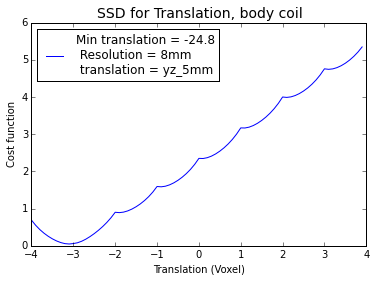

In [27]:
# Translation, cubic, with mask
rot_ax = 'yz'
res = '8mm'
testVol1 = oct13_dict_5mm_trans[res][rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_5mm_trans[res][rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
res = '8mm'
rad = res_to_rad(res)
trans = np.arange(-4,4,0.1)
wx,wy,wz = ax_to_w(axes_dict[rot_ax])
cost_t = trans_cost_func_3d(testVol1,testVol2, trans, wx,wy,wz,order=1,mask = False)
plot_cost_func_t(trans,cost_t,res,'%s_5mm'%rot_ax,'body')
plt.show()

In [97]:
from utils import rep_to_angle
def translation(volume,t):
        return ndimage.interpolation.shift(volume,t,order=1,mode='wrap')

Test Halton Sampling on Translations